In [1]:
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
from math import floor, sqrt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import ModelEvaluation_
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
X_data=np.load('./dataset/X_matrix.npy')
Y=pd.read_pickle('./dataset/Y.p')
Data_order=Y.index.values.astype(np.int16)
Y_data=Y.PSI.values.astype(np.float32)
Y_data[Y_data <= 0.10] = 0
Y_data[Y_data >= 0.70] = 1
data_selected = (Y_data == 0) + (Y_data == 1)
x_data = X_data[data_selected]
y_data = Y_data[data_selected]
data_order = Data_order[data_selected]
y_data=y_data.astype(np.int8)

In [3]:
# Remove the location information
x_data=x_data.sum(axis=2)>0

In [4]:
x_data.shape

(3786, 307)

## Split the data into 80% training and 20% testing

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=6666)

In [32]:
model = XGBClassifier(
                    n_estimators=500, learning_rate=0.1,
                    random_state=6666, n_jobs=-1,
                    max_depth=floor(sqrt(x_train.shape[1]))
                    )

In [33]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
probabilities = model.predict_proba(x_test)

In [34]:
acc = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, probabilities[:,1])
print('ACC: {}'.format(acc))
print('AUC: {}'.format(auc))

ACC: 0.816622691292876
AUC: 0.9204773869346734


## Find Importance Features

In [35]:
X=pd.read_pickle('./dataset/X.p')
TF_list=np.sort(np.unique(X[['TF']]))

In [10]:
top_k_imp=50
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
imp_TF_rank=TF_list[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_k_imp):
    print("%d. %s (%f)" % (f + 1, imp_TF_rank[f],  importances[indices[f]]))

Feature ranking:
1. T109678_1.02 (0.014479)
2. T106105_1.02 (0.013679)
3. T057697_1.02 (0.013559)
4. T057664_1.02 (0.012959)
5. T060516_1.02 (0.012319)
6. T057669_1.02 (0.011959)
7. T057730_1.02 (0.011039)
8. T082878_1.02 (0.010959)
9. T000289_1.02 (0.010919)
10. T142244_1.02 (0.010639)
11. T016893_1.02 (0.010479)
12. T057675_1.02 (0.010399)
13. T134210_1.02 (0.010079)
14. T016870_1.02 (0.009999)
15. T057806_1.02 (0.009759)
16. T057683_1.02 (0.009359)
17. T057682_1.02 (0.008799)
18. T134213_1.02 (0.008679)
19. T057850_1.02 (0.008439)
20. T138510_1.02 (0.008199)
21. T145683_1.02 (0.008199)
22. T057699_1.02 (0.008039)
23. T057701_1.02 (0.007719)
24. T084992_1.02 (0.007479)
25. T098477_1.02 (0.007479)
26. T057709_1.02 (0.007479)
27. T057760_1.02 (0.007399)
28. T078796_1.02 (0.007359)
29. T016873_1.02 (0.007319)
30. T136827_1.02 (0.007319)
31. T016887_1.02 (0.007199)
32. T057688_1.02 (0.007119)
33. T008731_1.02 (0.006839)
34. T016899_1.02 (0.006799)
35. T057791_1.02 (0.006719)
36. T082664_

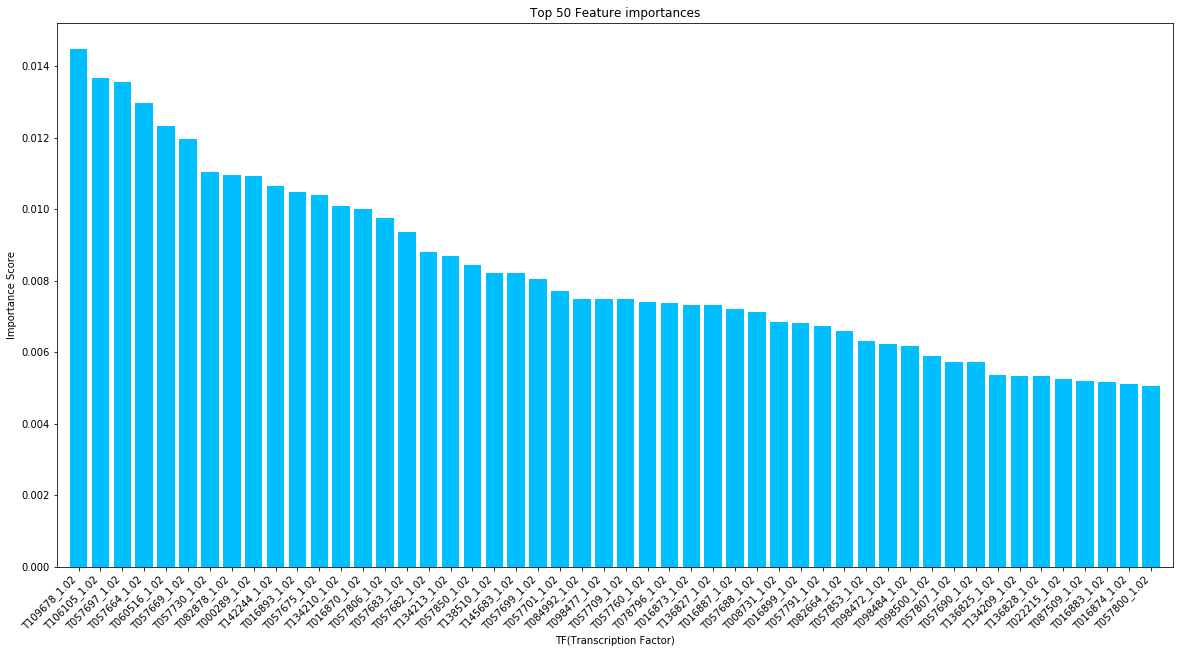

In [11]:
# Plot the feature importances of the Xgboost forest
fig = plt.figure(figsize=(20,10))
plt.title("Top 50 Feature importances")
plt.bar(range(top_k_imp), importances[indices][:top_k_imp], color='deepskyblue', align="center")
plt.xticks(range(top_k_imp), imp_TF_rank[:top_k_imp],rotation=45,horizontalalignment="right")
plt.xlim([-1, top_k_imp])
plt.xlabel('TF(Transcription Factor)')
plt.ylabel('Importance Score')

plt.show()

## Evaluate the Model with Confusion Matrix, F1-Score, ROC Curve, AUC...

### Confusion Matrix

|                | Predicted Positive | Predicted Negative |
|:--------------:|:------------------:|:------------------:|
|Actual Positive | TP (True Positive) | FN (False Negative)|
|Actual Negative | FP (False Positive)| TN (True Negative) |

Normalized confusion matrix
[[0.87 0.13]
 [0.25 0.75]]



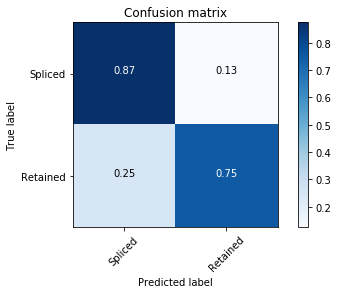

In [12]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
classes = np.asarray(['Spliced', 'Retained'])
ModelEvaluation_.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True)

### F1-Score
$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

$Precision = \frac{TP}{TP + FP}$

$Recall = \frac{TP}{TP + TN}$

$F1-score =2 \times {\frac{2}{\frac{1}{Recall} + \frac{1}{Precision}}} = 2 \times{\frac{Precision \times Recall}{Precision + Recall}}$

In [13]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall,f1_score,support=precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1_score))

Precision: 0.8202877164467446
Recall: 0.8135748185371301
F1 Score: 0.8147106667721825


### ROC Curve and AUC

In [14]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [15]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    
    Arguments:
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    encoding = np.eye(2)[x]
    return encoding

In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(one_hot_encode(y_test)[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

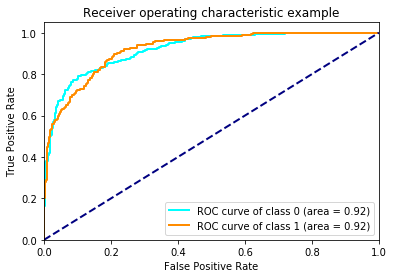

In [17]:
plt.figure()
lw = 2
#plt.plot(fpr[0], tpr[0], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
colors = cycle(['aqua', 'darkorange'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 5-fold Cross-Validation

In [23]:
data_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=6666)

In [24]:
def model_fit(x_train, x_test, y_train, y_test):
    """
    Fit model and return y_pred, acc, auc
    """
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    probabilities = model.predict_proba(x_test)

    acc = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, probabilities[:,1])
    return y_pred, acc, auc

In [60]:
cv_score = defaultdict()
cnf_matrix = []
importances = []
first_fold = True
fold = 1

for train_index, test_index in data_split.split(x_data, y_data, data_order):
    print('The %d th fold: ' % fold)
    X_train, X_test = x_data[train_index], x_data[test_index]
    Y_train, Y_test = y_data[train_index], y_data[test_index]
    model = XGBClassifier(
                    n_estimators=500, learning_rate=0.1,
                    random_state=6666, n_jobs=-1,
                    max_depth=floor(sqrt(x_train.shape[1]))
                    )
    if first_fold:
        cv_score['cv'] = {'acc': [], 'auc': []}
                    
    y_pred, acc, auc = model_fit(X_train, X_test, Y_train, Y_test)
    cv_score['cv']['acc'].append(acc)
    cv_score['cv']['auc'].append(auc)
    print('Accuracy: %.2f%%' % (acc * 100.0))
    print('AUC: %.3f' % auc)
    first_fold = False
    
    cnf = metrics.confusion_matrix(Y_test, y_pred)
    cnf_matrix.append(cnf)
    print('Confusion Matrix: \n',cnf)
    
    imp = model.feature_importances_
    importances.append(imp.tolist())
    top_10_indices = np.argsort(imp)[::-1][:10]
    top_10_TF = TF_list[top_10_indices]
    print('Top 10 Importance Features: \n')
    print(top_10_TF)
    fold+=1
    print()

The 1 th fold: 
Accuracy: 83.51%
AUC: 0.928
Confusion Matrix: 
 [[368  47]
 [ 78 265]]
Top 10 Importance Features: 

['T106105_1.02' 'T057697_1.02' 'T057669_1.02' 'T060516_1.02'
 'T057730_1.02' 'T057664_1.02' 'T109678_1.02' 'T000289_1.02'
 'T142244_1.02' 'T082878_1.02']

The 2 th fold: 
Accuracy: 83.49%
AUC: 0.931
Confusion Matrix: 
 [[364  50]
 [ 75 268]]
Top 10 Importance Features: 

['T106105_1.02' 'T057697_1.02' 'T057664_1.02' 'T109678_1.02'
 'T142244_1.02' 'T000289_1.02' 'T057806_1.02' 'T057730_1.02'
 'T057669_1.02' 'T016893_1.02']

The 3 th fold: 
Accuracy: 83.22%
AUC: 0.919
Confusion Matrix: 
 [[360  54]
 [ 73 270]]
Top 10 Importance Features: 

['T057669_1.02' 'T109678_1.02' 'T057697_1.02' 'T057730_1.02'
 'T106105_1.02' 'T000289_1.02' 'T016870_1.02' 'T057664_1.02'
 'T016893_1.02' 'T060516_1.02']

The 4 th fold: 
Accuracy: 82.03%
AUC: 0.909
Confusion Matrix: 
 [[361  53]
 [ 83 260]]
Top 10 Importance Features: 

['T109678_1.02' 'T106105_1.02' 'T057697_1.02' 'T057669_1.02'
 'T057

In [61]:
avg_acc = ModelEvaluation_.cross_validation_scores(cv_score['cv']['acc'], 'percentage')
avg_auc = ModelEvaluation_.cross_validation_scores(cv_score['cv']['auc'], 'decimal')

print('Accuracy: {}'.format(avg_acc))
print('AUC: {}'.format(avg_auc))

Accuracy: 83.44 +- 0.93%
AUC: 0.924 +- 0.009


Normalized confusion matrix
[[0.88 0.12]
 [0.22 0.78]]



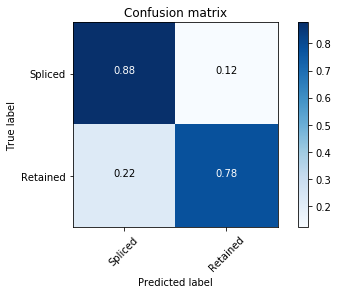

In [62]:
cnf_matrix = sum(cnf_matrix)
np.set_printoptions(precision=2)
classes = np.asarray(['Spliced', 'Retained'])
ModelEvaluation_.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True)

In [63]:
top_k_imp=50
importances=np.array(importances)
avg_importances = np.mean(importances,axis=0)
indices = np.argsort(avg_importances)[::-1]
imp_TF_rank=TF_list[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_k_imp):
    print("%d. %s (%f)" % (f + 1, imp_TF_rank[f],  avg_importances[indices[f]]))

Feature ranking:
1. T106105_1.02 (0.014262)
2. T109678_1.02 (0.014078)
3. T057697_1.02 (0.013909)
4. T057669_1.02 (0.013463)
5. T057730_1.02 (0.012457)
6. T057664_1.02 (0.012262)
7. T060516_1.02 (0.011338)
8. T000289_1.02 (0.011273)
9. T057806_1.02 (0.010726)
10. T142244_1.02 (0.010704)
11. T016870_1.02 (0.010565)
12. T016893_1.02 (0.010348)
13. T057675_1.02 (0.010220)
14. T082878_1.02 (0.009679)
15. T134210_1.02 (0.009649)
16. T057701_1.02 (0.009356)
17. T057682_1.02 (0.009267)
18. T057683_1.02 (0.008855)
19. T057699_1.02 (0.008573)
20. T016873_1.02 (0.008235)
21. T136827_1.02 (0.008182)
22. T057709_1.02 (0.007718)
23. T134213_1.02 (0.007687)
24. T084992_1.02 (0.007419)
25. T145683_1.02 (0.007393)
26. T057688_1.02 (0.007343)
27. T057850_1.02 (0.007331)
28. T138510_1.02 (0.007327)
29. T098477_1.02 (0.007065)
30. T057760_1.02 (0.007011)
31. T078796_1.02 (0.006920)
32. T016899_1.02 (0.006893)
33. T098500_1.02 (0.006224)
34. T082664_1.02 (0.006206)
35. T087509_1.02 (0.006170)
36. T057853_

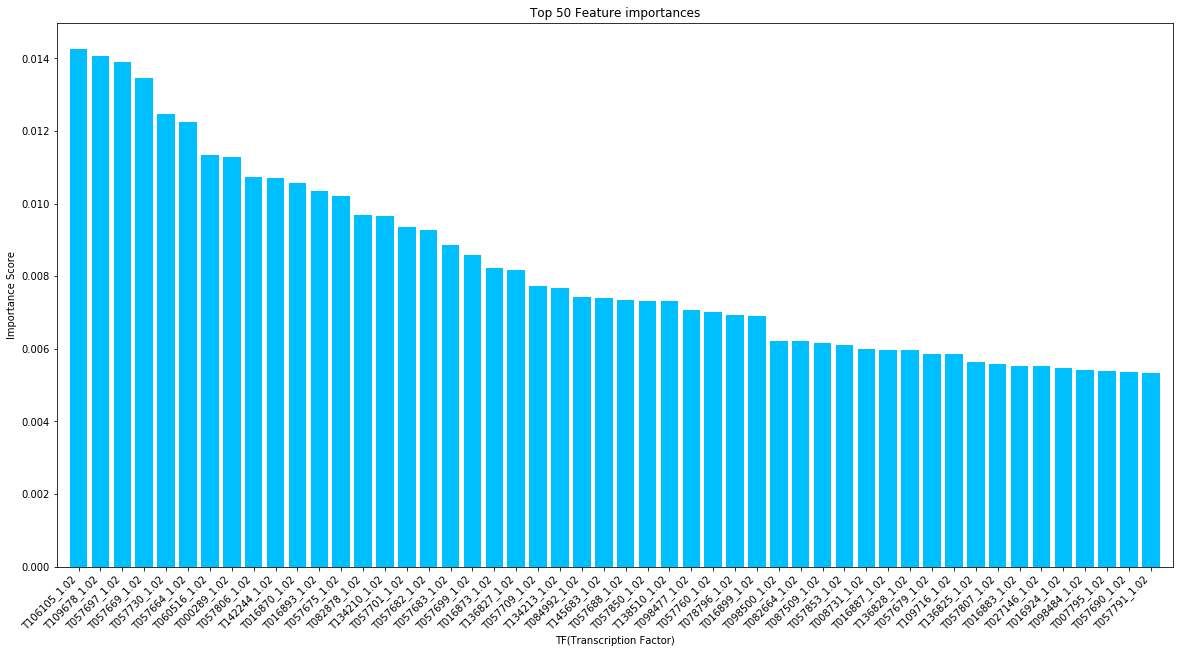

In [64]:
# Plot the feature importances of the Xgboost forest
fig = plt.figure(figsize=(20,10))
plt.title("Top 50 Feature importances")
plt.bar(range(top_k_imp), avg_importances[indices][:top_k_imp], color='deepskyblue', align="center")
plt.xticks(range(top_k_imp), imp_TF_rank[:top_k_imp],rotation=45,horizontalalignment="right")
plt.xlim([-1, top_k_imp])
plt.xlabel('TF(Transcription Factor)')
plt.ylabel('Importance Score')
plt.show()